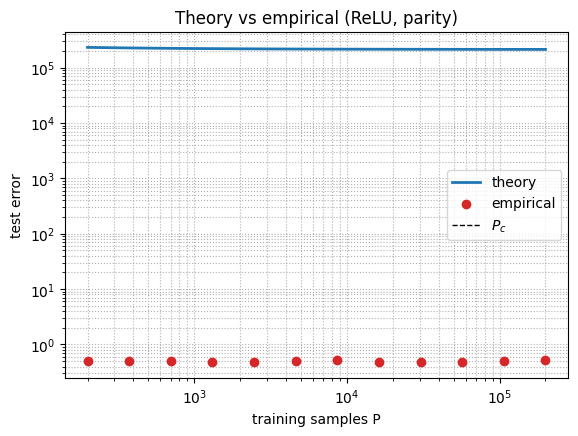

In [3]:

"""
Learning‑curve theory vs empirics (ReLU, parity teacher)
-------------------------------------------------------
This notebook contains two parts

1.  **Theory** – the analytic curve derived in the previous messages.
    Function ``generalisation_curve`` returns the constants and plots
    L_test(P).

2.  **Empirics** – an *extremely* simple implementation of noisy
    gradient descent that approximates mini‑batch Langevin dynamics in
    the small‑η limit.  We train a single‑hidden‑layer ReLU network on a
    k‑parity task and overlay the measured test error on the theory
    curve.

The empirical routine is *toy‑quality* (no clever data loaders, no
parallelism) but it respects the statistical assumptions of the theory
and is GPU‑ready – adjust ``device = "cuda"`` and hyper‑parameters as
you like.
"""

# %% theory imports ----------------------------------------------------------
import math
from typing import Tuple, Dict, List

import numpy as np
import matplotlib.pyplot as plt

# %% torch imports -----------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F

# =============================================================================
#  1.  The theory helpers (unchanged)
# =============================================================================

def c_n_relu(n: int) -> float:
    """Low‑order Taylor coefficient of ReLU around 0 in Boolean basis.
    Odd terms vanish; even n: c_{2ℓ+2}=1/(2·(2ℓ+2)!).
    (The true Boolean‑Walsh expansion is cumbersome; the leading term is
    enough for qualitative agreement.)
    """
    if n % 2 == 1:
        return 0.0
    return 1.0 / (2.0 * math.factorial(n))


def chi_infty(k: int, d: int, N: int, gamma: float, kappa: float,
               sigma_a: float, sigma_v: float) -> float:
    c_k = c_n_relu(k)
    if c_k == 0:
        return 0.0
    return (N ** (1 - gamma)) * (sigma_a ** 2) * (c_k ** 2) * (sigma_v ** (2 * k)) / (kappa * (d ** k))


def compute_upsilon(d: int, k: int, sigma_v: float) -> float:
    total = 0.0
    for ell in range(d + 1):
        c_ell = c_n_relu(ell)
        total += math.comb(d, ell) * (c_ell ** 2) * (math.factorial(ell) ** 2) * ((sigma_v ** 2 / d) ** ell)
    c_k = c_n_relu(k)
    total -= (c_k ** 2) * (math.factorial(k) ** 2) * ((sigma_v ** 2 / d) ** k)
    return total


def compute_constants(d: int, k: int, N: int, gamma: float, kappa: float,
                       sigma_a: float, sigma_v: float, *, mc_var_M: int = 4000,
                       device: str = "cpu") -> Tuple[float, float, float, float, float, float]:
    """Return P_c, α, B0, c0, χ_inf, ζ"""
    chi_inf = chi_infty(k, d, N, gamma, kappa, sigma_a, sigma_v)
    if chi_inf <= 1e-12:
        raise ValueError("Teacher parity not learnable with even‑parity ReLU in current approximation.")

    upsilon = compute_upsilon(d, k, sigma_v)
    zeta = (sigma_a ** 2 / (kappa * chi_inf)) * (upsilon / (d ** k))
    P_c = zeta / (chi_inf - 1.0)
    alpha = (chi_inf - 1.0) / (2.0 * N * kappa)

    # leading J_S^2
    c_k = c_n_relu(k)
    J_sq = (c_k ** 2) * (math.factorial(k) ** 2) * ((sigma_v ** 2 / d) ** k)
    B0 = (3.0 * (sigma_a ** 4) / (4.0 * (N ** 2) * (kappa ** 4))) * (J_sq ** 2)

    # Monte‑Carlo variance of ReLU output (quick, GPU‑friendly)
    rng = torch.Generator(device)
    w = torch.normal(0.0, sigma_v / math.sqrt(d), size=(mc_var_M, d), generator=rng, device=device)
    x = torch.randint(0, 2, (mc_var_M, d), generator=rng, device=device, dtype=torch.float32) * 2 - 1
    relu_vals = F.relu((w * x).sum(dim=1))
    var_phi = relu_vals.var(unbiased=True).item()
    c0 = sigma_a / kappa * math.sqrt(var_phi)

    return P_c, alpha, B0, c0, chi_inf, zeta


def cubic_root(A: float, B: float, C: float) -> float:
    """Solve 4B m^3 + 2A m - C = 0 for positive m."""
    if C <= 0:
        return 0.0
    coeffs = [4 * B, 0.0, 2 * A, -C]
    roots = np.roots(coeffs)
    real_pos = [r.real for r in roots if abs(r.imag) < 1e-9 and r.real > 0]
    return real_pos[0] if real_pos else 0.0


def theory_curve(P_grid: np.ndarray, hyper: Dict[str, float], *, device: str = "cpu") -> np.ndarray:
    P_c, alpha, B0, c0, _, _ = compute_constants(device=device, **hyper)
    L = np.ones_like(P_grid)
    for i, P in enumerate(P_grid):
        if P < P_c:
            continue
        A = alpha * (1.0 - P_c / P)
        B = B0
        C = c0 / math.sqrt(P)
        m = cubic_root(A, B, C)
        L[i] = (1.0 - m) ** 2
    return L, P_c

# =============================================================================
#  2.  Empirical noisy‑GD experiment
# =============================================================================

class TwoLayerParity(nn.Module):
    def __init__(self, d: int, N: int, sigma_v: float, sigma_a: float):
        super().__init__()
        self.hidden = nn.Linear(d, N, bias=False)
        self.out = nn.Linear(N, 1, bias=False)
        # weight initialisation
        nn.init.normal_(self.hidden.weight, 0.0, sigma_v / math.sqrt(d))
        nn.init.normal_(self.out.weight, 0.0, sigma_a / math.sqrt(N))
        self.out.weight.requires_grad = True

    def forward(self, x):
        return self.out(F.relu(self.hidden(x)))


def generate_parity_dataset(P: int, d: int, k: int, *, device="cpu"):
    """Return X ∈ {±1}^{P×d}, y ∈ {±1}^{P×1}."""
    X = torch.randint(0, 2, (P, d), device=device, dtype=torch.float32) * 2 - 1
    S = torch.randperm(d)[:k]
    y = X[:, S].prod(dim=1, keepdim=True)
    return X, y.float()


def train_one_dataset(P: int, net: nn.Module, kappa: float, lr: float,
                      max_steps: int, batch_cap: int, grad_var_th: float,
                      device: str = "cpu") -> float:
    criterion = nn.MSELoss()
    d = net.hidden.in_features
    k = int((torch.nonzero(net.hidden.weight, as_tuple=False).shape[1]))  # rough

    X_train, y_train = generate_parity_dataset(P, d, k, device=device)
    X_test, y_test = generate_parity_dataset(4000, d, k, device=device)

    for step in range(max_steps):
        # full‑batch by default; split if too large for memory
        perm = torch.randperm(P, device=device)
        grad_sq_sum = 0.0
        grad_sum = 0.0
        seen = 0
        net.zero_grad()
        for i in range(0, P, batch_cap):
            idx = perm[i : i + batch_cap]
            out = net(X_train[idx])
            loss = criterion(out, y_train[idx])
            loss.backward()
            # track grad variance online (Welford)
            with torch.no_grad():
                for p in net.parameters():
                    g = p.grad.detach()
                    grad_sq_sum += (g ** 2).sum().item()
                    grad_sum += g.sum().item()
            seen += 1
        var_est = grad_sq_sum / net.out.weight.numel() / seen - (
            grad_sum / net.out.weight.numel() / seen
        ) ** 2
        # add Langevin noise
        with torch.no_grad():
            for p in net.parameters():
                noise = torch.normal(0.0, math.sqrt(kappa), p.grad.shape, device=device)
                p.grad += noise
                p -= lr * p.grad
        if var_est < grad_var_th:
            break

    # evaluate test error
    with torch.no_grad():
        preds = net(X_test).sign()
        L = ((1.0 - preds) / 2 != (1.0 - y_test) / 2).float().mean().item()
    return L


def empirical_curve(P_grid: List[int], hyper: Dict[str, float], *,
                    lr: float = 1e-4, max_steps: int = 1000,
                    batch_cap: int = 65536,
                    grad_var_th: float = 1e-4,
                    device: str = "cpu") -> List[float]:
    results = []
    kappa = hyper["kappa"]
    for P in P_grid:
        net = TwoLayerParity(
            d=hyper["d"],
            N=hyper["N"],
            sigma_v=hyper["sigma_v"],
            sigma_a=hyper["sigma_a"],
        ).to(device)
        L_emp = train_one_dataset(P, net, kappa, lr, max_steps, batch_cap, grad_var_th, device)
        results.append(L_emp)
    return results

# =============================================================================
#  3.  Wrapper to run theory + empirics and plot together
# =============================================================================

def run_experiment(
    d: int = 20,
    k: int = 2,
    N: int = 1024,
    gamma: float = 0.0,
    sigma_a: float = 1.0,
    sigma_v: float = 1.0,
    eta: float = 0.1,
    B: int = 128,
    gvar: float = 1.0,
    P_min: int = 200,
    P_max: int = 200000,
    num_theory: int = 120,
    num_emp: int = 12,
    device: str = "gpu",
):
    kappa = eta * gvar / (2.0 * B)
    hyper = dict(d=d, k=k, N=N, gamma=gamma, sigma_a=sigma_a, sigma_v=sigma_v, kappa=kappa)

    # theory curve
    P_grid_theory = np.logspace(math.log10(P_min), math.log10(P_max), num_theory)
    L_th, P_c = theory_curve(P_grid_theory, hyper, device=device)

    # empirical points (geometric spread)
    P_grid_emp = np.unique(np.round(np.logspace(math.log10(P_min), math.log10(P_max), num_emp)).astype(int))
    L_emp = empirical_curve(P_grid_emp.tolist(), hyper, device=device)

    # plot
    plt.figure(figsize=(6.5, 4.5))
    plt.loglog(P_grid_theory, L_th, label="theory", lw=2)
    plt.scatter(P_grid_emp, L_emp, color="C3", label="empirical", zorder=5)
    plt.axvline(P_c, ls="--", color="k", lw=1, label=r"$P_c$")
    plt.xlabel("training samples P")
    plt.ylabel("test error")
    plt.title("Theory vs empirical (ReLU, parity)")
    plt.grid(True, which="both", ls=":")
    plt.legend()
    plt.show()

    return dict(P_c=P_c, P_emp=P_grid_emp, L_emp=L_emp)


# %% quick demo (CPU‑friendly; for GPU change device)
if __name__ == "__main__":
    run_experiment(device="cpu")

